# 뉴스 기사 요약해보기
## 추출적 요약 / 추상적 요약

In [1]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from importlib.metadata import version
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
import tensorflow
import summa
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')
print(nltk.__version__)
print(tensorflow.__version__)
print(version('summa'))

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


3.6.5
2.6.0
1.2.0


데이터 다운로드

In [2]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
print(data.info())
data.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98401 entries, 0 to 98400
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   headlines  98401 non-null  object
 1   text       98401 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB
None


,headlines,text
94743,South Africa lifts ban on domestic rhino horn ...,South Africa's Constitutional Court has dismis...
54277,2018 mein bhi gaaliyan khaani hain: SRK to Rai...,"Actor Shah Rukh Khan, while addressing his upc..."
63718,Photo of missing J&K cop holding an AK-47 surf...,A photo of a missing Jammu and Kashmir police ...
8572,"SL bowler delivers 12 no-balls in 1 session, u...",As many as 12 out of 30 deliveries that Sri La...
5984,"Lyon takes 5-for, Kohli hits 25th Test ton as ...",Australia ended the third day of the second Te...
38848,"5-yr-old stepchild testifies, man gets life te...",The Delhi High Court upheld a man's life sente...
8525,Muslim sisters meet Sikh brother for 1st time ...,"Two Muslim sisters and their Sikh brother, who..."
97588,I have faced sexual harassment at work: Twinkl...,Twinkle Khanna revealed that she has faced sex...
32040,Berlin plans to reduce crayfish population by ...,German capital Berlin is planning to reduce th...
22443,Ex-400m hurdles world champ dies in car crash ...,"Nicholas Bett, the former 400m hurdles world c..."


text 컬럼이 input이 되고 headlines 컬럼이 target이 될 듯 하다

## 데이터 전처리
### 중복, 결측치 제거
중복 샘플 상태 확인

In [4]:
print('text 중복 제외 : ', data['text'].nunique())
print('headlines 중복 제외 : ', data['headlines'].nunique())

text 중복 제외 :  98360
headlines 중복 제외 :  98280


drop_duplicates()를 사용하여 중복 샘플을 제거

In [5]:
data.drop_duplicates(subset=['text'], inplace=True)
len(data)

98360

결측치 확인(없음)

In [6]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

### 텍스트 정규화와 불용어 제거
같은 뜻이지만 다르게 쓰이는 경우  
i am = i'm과 같이 같은 표현을 같은 단어로 간주하게하여 모델의 연산량 증가를 막는 과정  
EXP 12에서 쓰인 정규화 사전 및 불용어 리스트를 사용  
(참고링크 : https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python)

In [7]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [8]:
print('불용어 :', len(stopwords.words('english')), '개' )
print(stopwords.words('english'))

불용어 : 179 개
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so

함수를 통해 알파벳 소문자화, 특수문자 제거, 불용어 제거 등 전처리

In [9]:
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower()
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [10]:
clean_text = []
# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("text 전처리 후 결과: ", clean_text[:5])

text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [11]:
clean_headline = []
# 전체 headlines 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['headlines']:
    clean_headline.append(preprocess_sentence(s, False))

print("headline 전처리 후 결과: ", clean_headline[:5])

headline 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


전처리 된 데이터를 원본 데이터에 덮어씌우기

In [12]:
data['text'] = clean_text
data['headlines'] = clean_headline

In [13]:
# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [14]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

## 훈련 데이터, 테스트 데이터 나누기
그 전 전처리된 데이터의 상태를 확인하고,  
필요한 범위 내의 데이터만 사용할 수 있도록 정리한다.

In [15]:
text_len = [len(s.split()) for s in data['text']]
headline_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('헤드라인의 최소 길이 : {}'.format(np.min(headline_len)))
print('헤드라인의 최대 길이 : {}'.format(np.max(headline_len)))
print('헤드라인의 평균 길이 : {}'.format(np.mean(headline_len)))


텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
헤드라인의 최소 길이 : 1
헤드라인의 최대 길이 : 16
헤드라인의 평균 길이 : 9.299532330215534


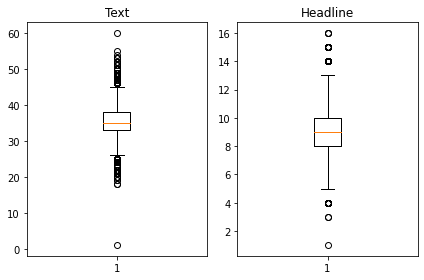

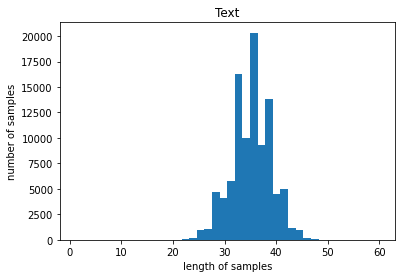

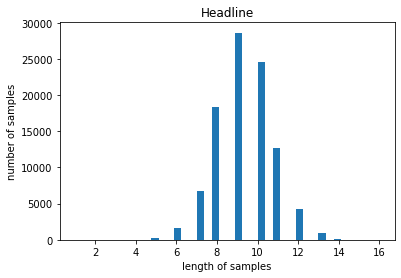

In [16]:
import matplotlib.pyplot as plt

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(headline_len)
plt.title('Headline')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Headline')
plt.hist(headline_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

데이터의 분포가 고르게 되어있어 그대로 사용해도 될 듯 하다.

### 시작 토큰 sos와 종료 토큰 eos 추가하기
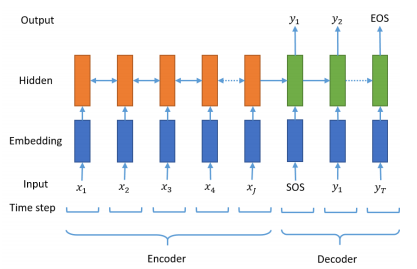
문장의 시작에 sos 토큰을, 문장의 끝에 eos 토큰을 각각 추가해준다.  
decoder_input = 디코더 인풋으로 들어가며, 시작 토큰이 앞에 있는 문장  
decoder_output = 디코더 출력에 해당되며, 종료 토큰이 뒤에 붙은 문장

In [17]:
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


다시 넘파이 타입으로 저장

In [18]:
encoder_input = np.array(data['text'])            # 인코더의 입력
decoder_input = np.array(data['decoder_input'])   # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

### 훈련, 테스트 데이터 나누기  
분리 방법은 분리 패키지를 이용하는 방법이 편하지만,  
직접 과정을 설계하는 방식으로 진행

In [19]:
# encoder_input과 크기와 형태가 같은 임의의 정수 시퀸스를 생성
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)
len(encoder_input), len(indices)

[12272 97093 35746 ... 85185 81082 19811]


(98360, 98360)

위의 난수를 이용하여 데이터 샘플의 순서를 섞어준다.

In [20]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

다음으로 섞인 데이터를 8:2 비율로 분리  
전체 길이에 0.2를 곱하여 테스트 데이터의 크기를 정의한다.

In [21]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터 : ', n_of_val)

테스트 데이터 :  19672


19672 라는 값을 이용해 슬라이싱으로 각각 나눈다.

In [22]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터 :', len(encoder_input_train))
print('훈련 레이블 :', len(decoder_input_train))
print('테스트 데이터 :', len(encoder_input_test))
print('테스트 레이블 :', len(decoder_input_test))

훈련 데이터 : 78688
훈련 레이블 : 78688
테스트 데이터 : 19672
테스트 레이블 : 19672


train : test = 78688 : 19672 로 나누어졌다.

### 단어 집합 (vocabulary) 만들기, 정수 인코딩
모델이 학습할 수 있도록 단어를 모두 정수로 바꾸어주어야한다  
단어와 고유한 정수를 맵핑하는 과정을 단어 집합을 만든다고 표현  
keras의 토크나이저를 사용

In [23]:
src_tokenizer = Tokenizer() 
src_tokenizer.fit_on_texts(encoder_input_train) # 입력 데이터로 단어 집합 생성

단어 집합은 src_tokenizer.word_index에 저장되었다  
src_tokenizer.word_countx.items()에 각 단어와 단어의 등장 빈도수가 저장되어 통계적 정보를 얻을 수 있음

In [25]:
threshold = 8
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69531
등장 빈도가 7번 이하인 희귀 단어의 수: 48871
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 20660
단어 집합에서 희귀 단어의 비율: 70.28663473846198
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.854591547725609


등장 빈도가 threshold값인 8보다 작은 단어들의 비율은 약 70%정도이다.  
그러나 실제로 훈련 데이터에서의 등장 빈도의 비율은 약 3.9%로 매우 낮다.  
등장 빈도가 낮은 단어들을 데이터에서 제외시킨 후 인코딩을 한다.  
희귀 단어를 제외한 후 단어 집합 크기를 어림잡아 20000으로 생각하고  
토크나이저 정의 시 num_words 값에 지정해주면 단어 집합 크기를 제한할 수 있다.

In [26]:
src_vocab = 20000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기 제한
src_tokenizer.fit_on_texts(encoder_input_train)

텍스트를 정수 시퀸스로 변환

In [27]:
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

In [29]:
print(encoder_input_train[:3])

[[738, 54, 835, 366, 1562, 216, 184, 62, 3676, 19423, 28, 327, 59, 1, 5000, 90, 738, 16004, 48, 835, 4280, 1287, 134, 1193, 7913, 9133, 922, 48, 2936, 780, 1576, 1138, 2841], [81, 4281, 6616, 1, 2, 6105, 10975, 302, 241, 1172, 302, 241, 10975, 1413, 4, 4281, 163, 906, 172, 574, 15, 8279, 1, 1723, 732, 35, 10714, 4540], [6259, 194, 1518, 334, 87, 9, 68, 54, 1155, 429, 1259, 468, 601, 43, 468, 2146, 150, 22, 74, 237, 412, 182, 17, 13385, 1518, 197, 3309, 226]]


decoder_input 데이터에도 적용

In [30]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [32]:
threshold = 8
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 30042
등장 빈도가 7번 이하인 희귀 단어의 수: 21288
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 8754
단어 집합에서 희귀 단어의 비율: 70.86079488715798
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.967559830457235


위와 같이 등장 빈도가 8회 미만인 것을 제외하고  
단어 집합의 크기를 8500으로 잡음

In [33]:
tar_vocab = 8500
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 2530, 857, 9, 599, 1702, 183, 4], [1, 8, 19, 4550, 6, 48, 3517], [1, 305, 189, 846, 746, 298, 4268], [1, 5426, 1442, 3329, 14, 1800, 4411, 2275], [1, 141, 10, 6845, 141, 5, 1390, 199, 48, 68, 30]]
target
decoder  [[2530, 857, 9, 599, 1702, 183, 4, 2], [8, 19, 4550, 6, 48, 3517, 2], [305, 189, 846, 746, 298, 4268, 2], [5426, 1442, 3329, 14, 1800, 4411, 2275, 2], [141, 10, 6845, 141, 5, 1390, 199, 48, 68, 30, 2]]


위의 과정에서 희귀단어들을 제외하는 과정 중  
만약 희귀단어로만 구성되어있는 데이터는 어떻게 되었을까?  
아마 샘플이 빈 상태로 남아있을것이다.  
이 현상은 상대적으로 문장 길이가 길었던 text 데이터보다 짧은 headlins 에서 더욱 돋보일것이며,  
decoder_input / decoder_output에서는 각각 시작토큰과 종료토큰때문에 길이가 1로 출력이 될 것이다.

In [35]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 1
훈련 데이터의 개수 : 78688
훈련 레이블의 개수 : 78688
테스트 데이터의 개수 : 19671
테스트 레이블의 개수 : 19671


샘플들의 길이를 맞춰주기위해 최대 길이만큼 패딩을 넣어준다.

In [38]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=np.max(text_len), padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=np.max(text_len), padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=np.max(headline_len), padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=np.max(headline_len), padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=np.max(headline_len), padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=np.max(headline_len), padding='post')